# Lab Assignment One: Exploring Table Data
Name: Marc Pham, Alonso Gurrola

## 1. Preparation and Overview

### 1.1: Business Understanding

The data, funded by the Instituto Politécnico de Portalegre on April 23, 2021, aims to identify students at risk of dropping out of higher education.  The dataset includes 4,424 students who are classified as dropouts, current enrollees, or graduates.  For each student, the data includes 37 total features, including demographic features (e.g., race and gender) and economic factors (e.g., the inflation rate and unemployment rate at the time of their application) that may influence their likelihood for dropping out.  The funders’ original goal was to use machine learning techniques to detect which students are at risk of dropping out and implement targeted interventions, such as scholarships, to support these students.

The end goal of analyzing this dataset is to classify a student as a potential dropout or an enrollee/graduate based on economic factors and each student’s demographic features.  The results can help university admissions offices and government agencies determine which groups of students need additional support to get through higher education.  However, it is important to note that third parties could use these results to choose which students to accept or deny from a university.  Keeping this in mind, the final classification algorithm should not be trained on race since the Supreme Court banned the use of race in college admissions.  The final model will need to be deployed, so third-parties can keep checking if students are at risk of dropping out as the students go through their first and second semesters. Deploying the model also allows third-parties to determine if a student's risks of dropping out gets worse or better as they continue to go through school.

For the algorithm to be successful, we need the algorithm to accurately classify which students are dropping out.  It is less important if the model inaccurately predicts an Enrollee as a Graduate or vice versa.  As a result, we should use metrics like precision and recall to measure how well the algorithm does at classifying dropouts.  For our algorithm, recall measures the percentage of actual dropouts that the algorithm correctly classifies.  Our recall should be as close as possible to 100% to minimize the probability of missing any students at risk of dropping out.  Precision measures the percentage of students predicted to drop out who are actual dropouts.  Low precision means we are giving additional resources to many students not at risk of dropping out, while high precision means that resources are used effectively.  Although high precision is ideal, it would be acceptable to have lower precision, like 70%, if it significantly increases recall.  The balance between precision and recall will depend on how much financial flexibility institutions have.

Sources: [Dataset](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success)

M.V.Martins, D. Tolledo, J. Machado, L. M.T. Baptista, V.Realinho. (2021) "Early prediction of student’s performance in higher education: a case study" Trends and Applications in Information Systems and Technologies, vol.1, in Advances in Intelligent Systems and Computing series. Springer. DOI: 10.1007/978-3-030-72657-7_16

### 1.2: Data Preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize_scalar, fmin_bfgs
from numpy.linalg import pinv
from sklearn.metrics import accuracy_score
from scipy.special import expit
import copy
import time
from numpy import ma # (masked array) this has most numpy functions that work with NaN data.
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data.csv', sep=';')
df = df.rename(columns = {
    'Daytime/evening attendance\t' : 'Daytime/evening attendance',               
    'Nacionality': 'Nationality'})
df['Target'].replace({'Dropout' : 1, 'Enrolled' : 2, 'Graduate' : 3}, inplace=True);

To determine which of the 37 features should be the most helpful, it is important to determine which features appear to be the most correlated with the target variable. In Lab One, we determined this with a correlation table, which orders the features from those with the strongest correlation (in magnitude) to those with the weakest correlation. A feature with a positive correlation is correlated with a lower chance to drop out; a feature with a negative correlation is correlated with a high chance to drop out.

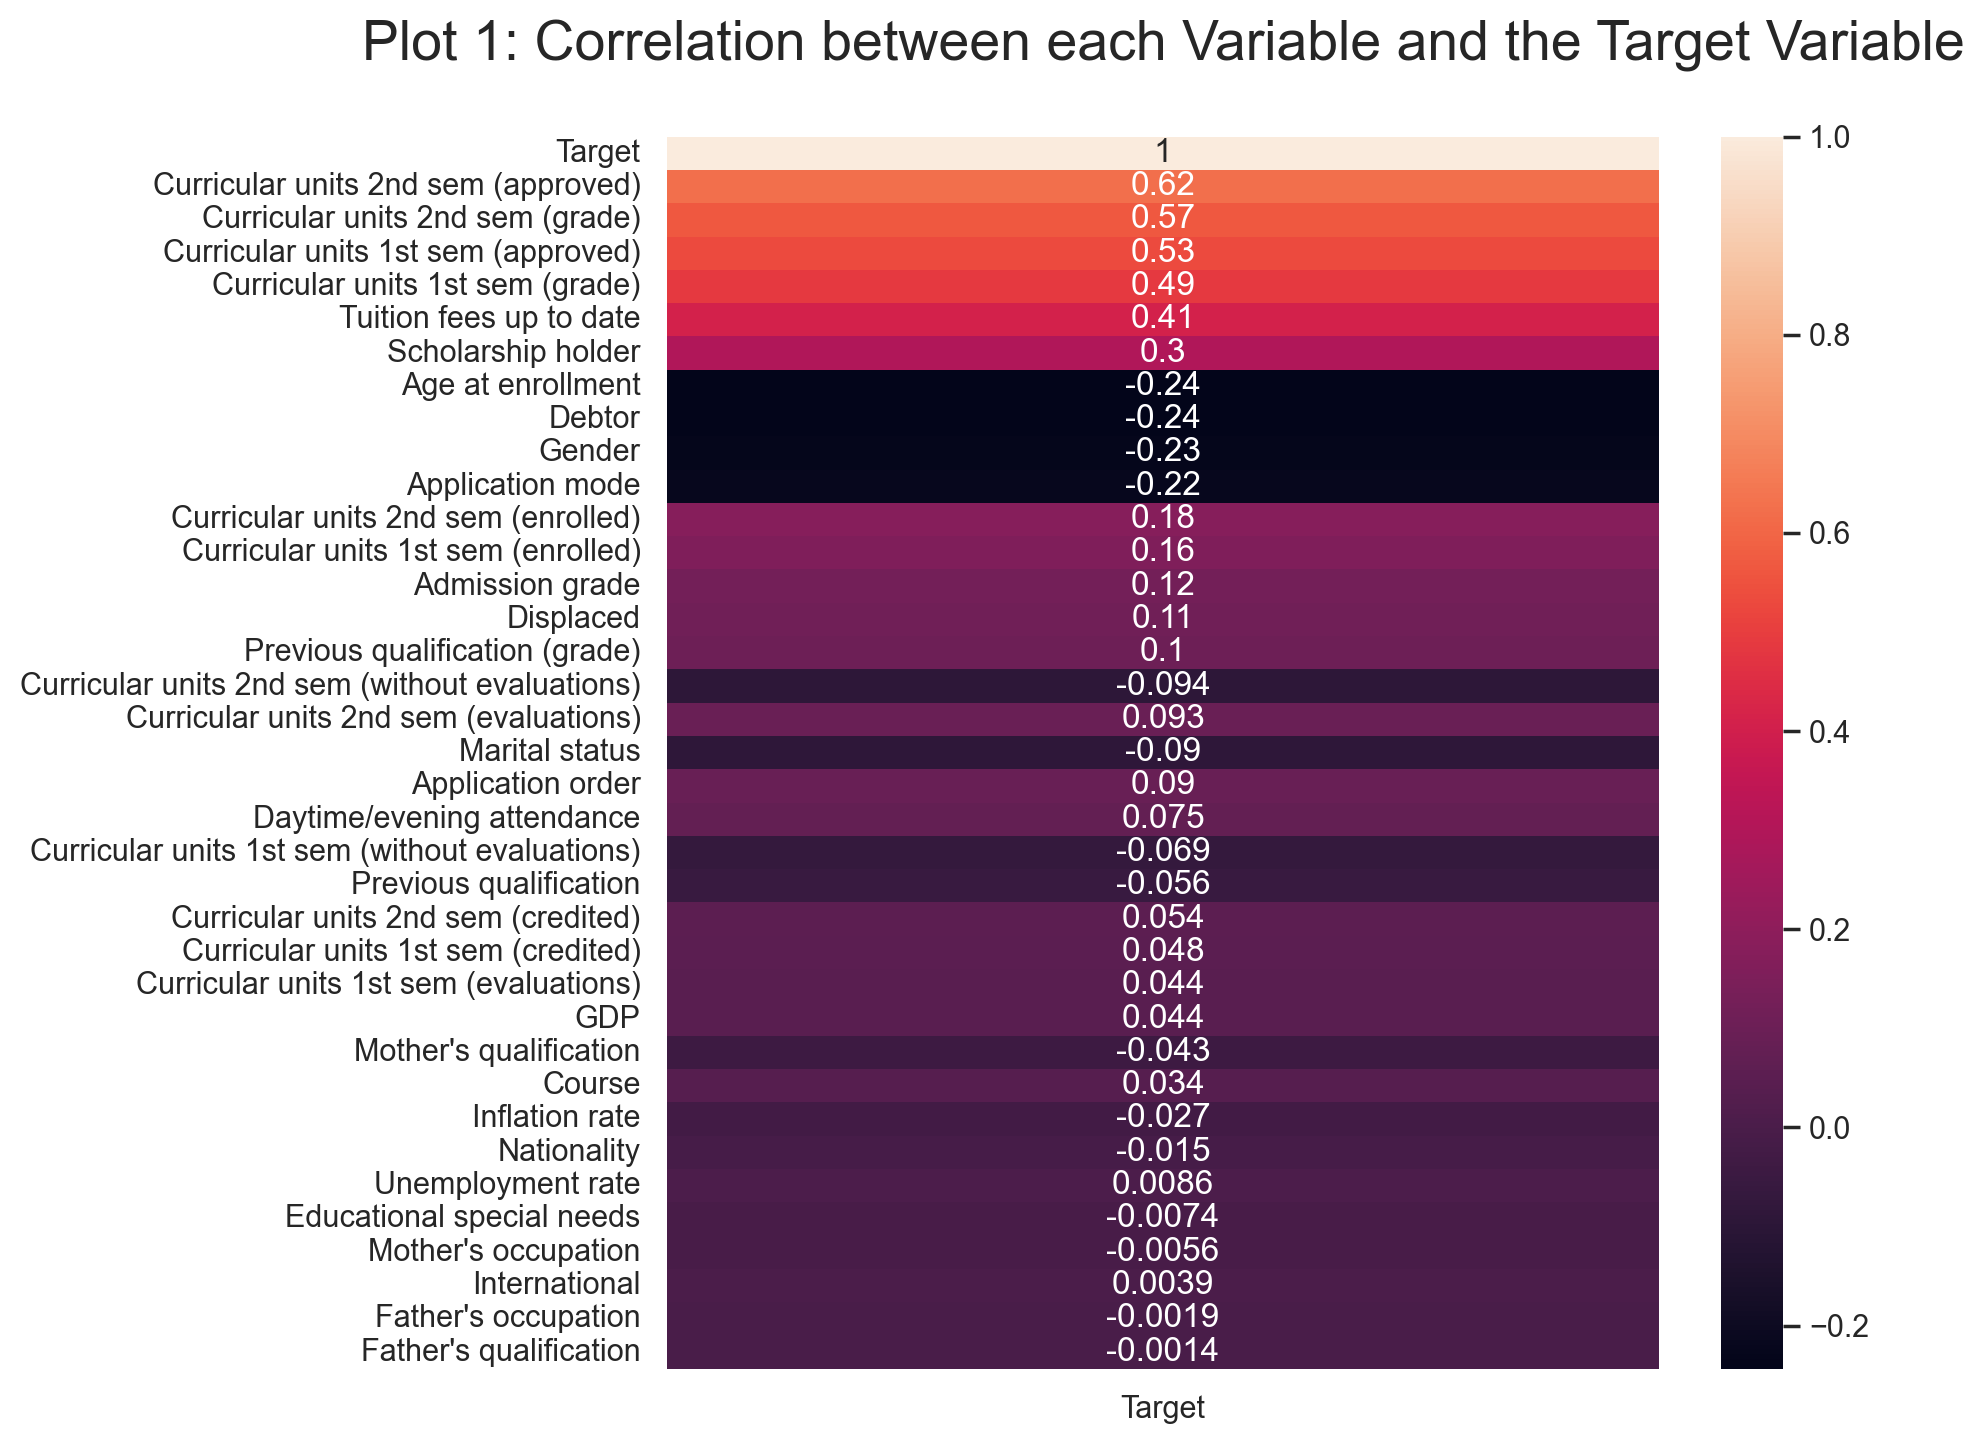

In [3]:
df_target = df.corr()[['Target']]
df_target['abs(Target)'] = df_target['Target'].abs()

cmap = sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(8, 8), dpi=200)
corrs = pd.DataFrame(df_target.sort_values(by='abs(Target)', ascending=False)['Target'])

# Sort the Correlation Coefficients by its Magnitude but output the raw Correlation Coefficient.
sns.heatmap(corrs, cmap=cmap, annot=True);
ax.set_title("Plot 1: Correlation between each Variable and the Target Variable\n", fontsize=20);


The correlation table indicates that several features are unlikely to help us predict whether or not a student will drop out. In our analysis, we decided to remove all features with a correlation magnitude below 0.1 because keeping them may reduce the model's accuracy by including irrelevant information. This leaves us with 15 features. The only categorical variable with multiple possible values is Application Mode, which we will one-hot encode.


In [4]:
df_less = df[corrs[abs(corrs['Target']) >= 0.1].transpose().columns]
df_less = pd.get_dummies(df_less, prefix='AppMode', columns=['Application mode'], dtype=int)

X = df_less.drop('Target', axis=1)
y = df_less['Target']

**Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). Provide a breakdown of the variables after preprocessing (such as the mean, std, etc. for all variables, including numeric and categorical).**

In [19]:


# Separate numeric and categorical features
numeric_features = X.select_dtypes(include=['int64', 'float64'])
categorical_features = X.select_dtypes(include=['uint8'])

# Descriptive statistics for numeric features (mean, std)
numeric_summary = numeric_features.describe().transpose()

# Check if there are any categorical features to process
if not categorical_features.empty:
    # Mode for categorical features
    categorical_summary = categorical_features.mode().transpose()
    categorical_summary.columns = ['Mode']
else:
    categorical_summary = pd.DataFrame({'Message': ['No categorical features present']})

# Standard scaling for numeric features
scaler = StandardScaler()
scaled_numeric_features = pd.DataFrame(scaler.fit_transform(numeric_features), columns=numeric_features.columns)

# Combine the scaled numeric features with the original categorical ones (if any)
final_dataset = pd.concat([scaled_numeric_features, categorical_features], axis=1)

# Display the numeric summary
print("Numeric Summary:\n", numeric_summary)

# Display the categorical summary
if not categorical_summary.empty:
    print("\nCategorical Summary:\n", categorical_summary)

# Show final dataset breakdown after scaling
print("\nFinal Dataset Breakdown:\n", final_dataset.describe().transpose())

Numeric Summary:
                                       count        mean        std   min  \
Curricular units 2nd sem (approved)  4424.0    4.435805   3.014764   0.0   
Curricular units 2nd sem (grade)     4424.0   10.230206   5.210808   0.0   
Curricular units 1st sem (approved)  4424.0    4.706600   3.094238   0.0   
Curricular units 1st sem (grade)     4424.0   10.640822   4.843663   0.0   
Tuition fees up to date              4424.0    0.880651   0.324235   0.0   
Scholarship holder                   4424.0    0.248418   0.432144   0.0   
Age at enrollment                    4424.0   23.265145   7.587816  17.0   
Debtor                               4424.0    0.113698   0.317480   0.0   
Gender                               4424.0    0.351718   0.477560   0.0   
Curricular units 2nd sem (enrolled)  4424.0    6.232143   2.195951   0.0   
Curricular units 1st sem (enrolled)  4424.0    6.270570   2.480178   0.0   
Admission grade                      4424.0  126.978119  14.482001  95

The final dataset after preprocessing includes standardized numeric features (such as “Curricular units”, “Admission grade”, and “Age at enrollment”), which have been normalized to have a mean of 0 and a standard deviation of 1, ensuring they are on the same scale. Categorical features like “Application mode” have been one-hot encoded into binary columns. There are no remaining categorical variables requiring a mode calculation. This preprocessing ensures that all features, both numeric and categorical, are ready for use in classification or regression models, with appropriate normalization and encoding applied.

In [5]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(X)

pca = PCA(0.90)
X_final = pca.fit_transform(df_scaled)
print(f"Number of PCA Components: {len(X_final[0])}")

Number of PCA Components: 22


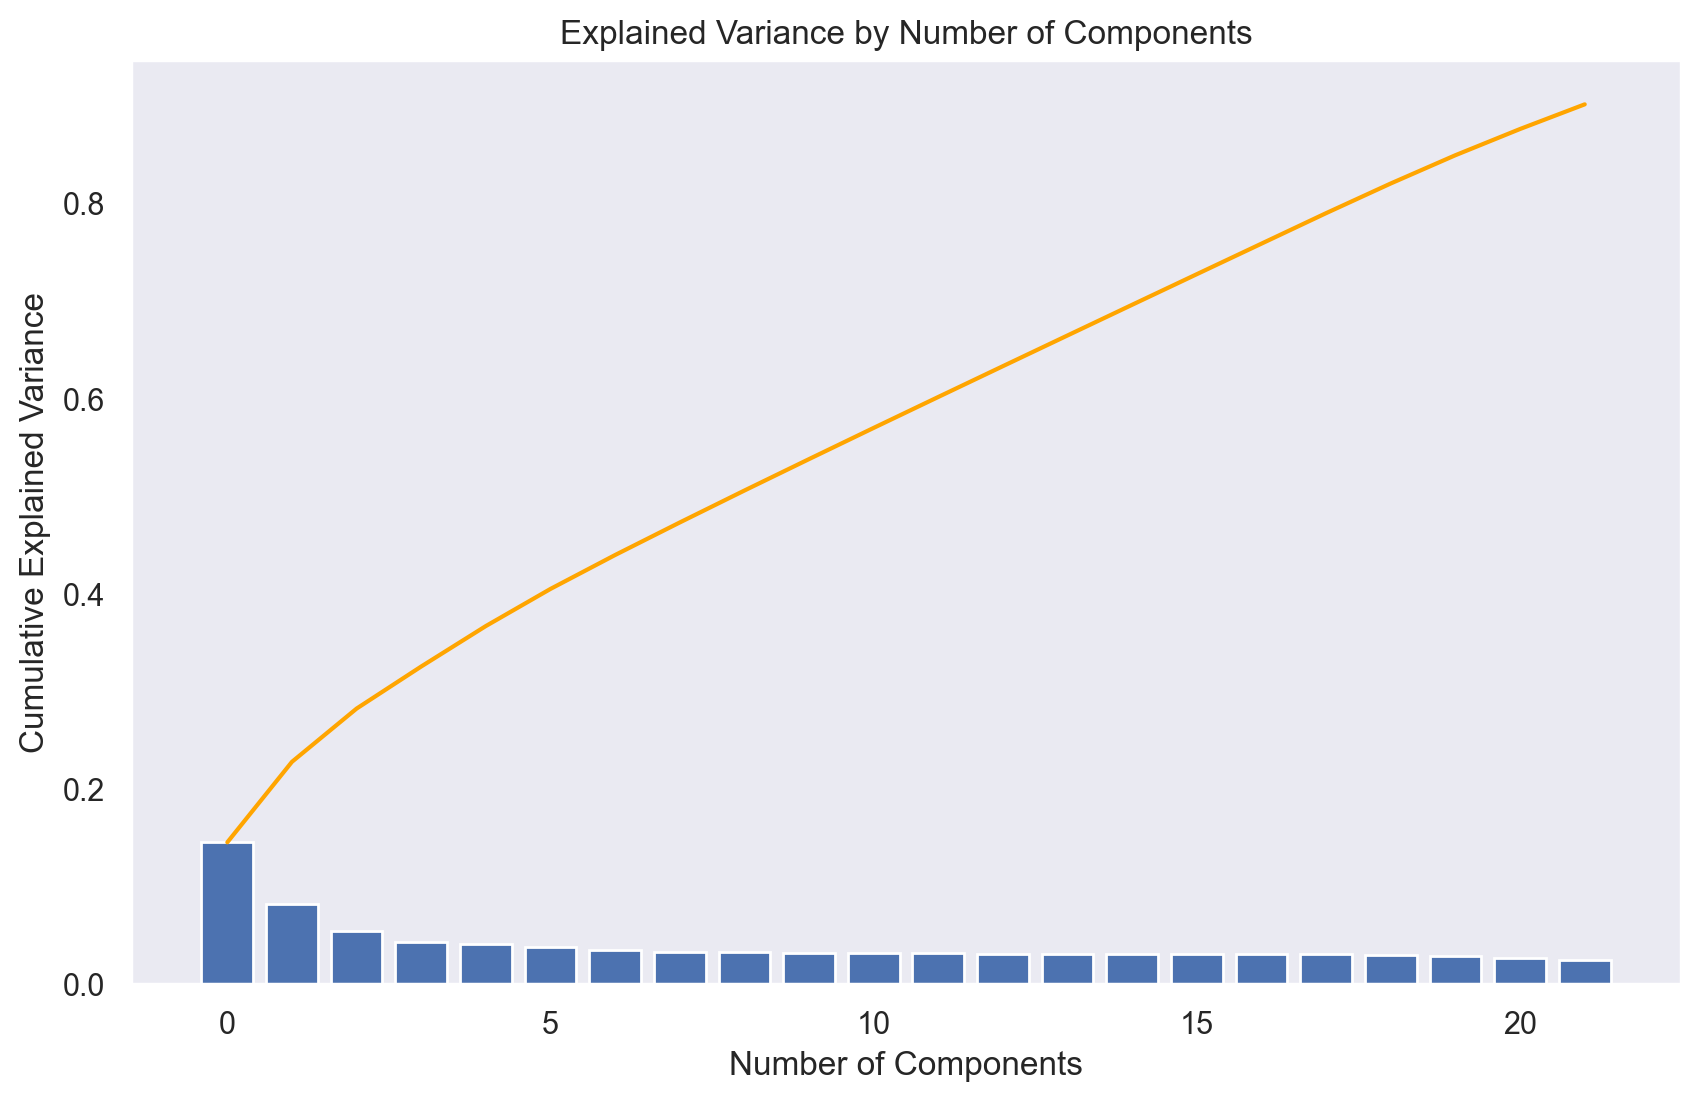

In [6]:
plt.figure(figsize=(10, 6), dpi=200)
plt.plot(np.cumsum(pca.explained_variance_ratio_), c='orange')
plt.bar(np.arange(0, len(X_final[0])), pca.explained_variance_ratio_)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')
plt.grid()
plt.show()

Upon examining the Explained Variance for different numbers of components, we noticed that there is not a clear point where the cumulative explained variance stabilizes. Therefore, we opted to keep enough components to ensure at least 90% of the variance is explained, which led us to keep 22 PCA components.

### 1.3: Train-Test Split

Applying an 80-20 train-test split is beneficial for our data since it reduces the risk of overfitting the model to the training data. The test set lets us to determine if the model generalizes to unseen data, which gives us valuable insight into how the model will perform when deployed. While one potential drawback of the 80-20 split is that it reduces the amount of data available for training the model, our dataset of 4,424 students is large enough that we still have 3,539 examples to train on after the split.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2)
print(f"Training Data Shape: {X_train.shape}, Testing Data Shape: {X_test.shape}")

Training Data Shape: (3539, 22), Testing Data Shape: (885, 22)


## 2. Modeling

### 2.1: One vs. All Logistic Regression Classifier

In [8]:
# allow for the user to specify the algorithm they want to solver the binary case
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver = "default",
                 regularization = "none", 
                 line_iters=8
                 ):
        self.eta = eta
        self.iters = iterations
        self.C = C
        
        self.solver = solver
        self.classifiers_ = []

        if solver == "stochastic":
            self._get_gradient = self.stochastic
            self.train = self.default_fit
        elif solver == "steepest_ascent": 
            self.train = self.fit_steepest
            self.objective_function = self.objective_steepest
            # self.orig_eta = eta
            self.line_iters = line_iters
        elif solver == "newton":
            self._get_gradient = self.newton
            self.train = self.default_fit
        elif solver == "quasi":
            self.train = self.fit_bfgs
            self.objective_function = self.objective_quasi
            # self.objective_function = self.mse_quasi
        else:
            self._get_gradient = self.default_gradient
            self.train = self.default_fit

        if regularization == "l1":
            self.regularization_objective = self.L1_objective
            self.regularization_gradient = self.L1_gradient
        elif regularization == "l2":
            self.regularization_objective = self.L2_objective
            self.regularization_gradient = self.L2_gradient
        elif regularization == "elasticnet":
            self.regularization_objective = self.elasticnet_objective
            self.regularization_gradient = self.elasticnet_gradient
        else:
            self.regularization_objective = self.zero
            self.regularization_gradient = self.zero
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []

        self.w_ = []
        
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class

            trained_weights = self.train(X,y_binary)
            self.w_.append(trained_weights.flatten())
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.array(self.w_)
        
    def predict_proba(self,X,add_bias=True):
        probs = []
        
        for weights in self.w_:
            Xb = self._add_bias(X) if add_bias else X
            probs.append(
                self._sigmoid(Xb @ weights).reshape((len(X),1))
            )
            
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row

        # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    """
    All Regularization Functions
    """
    def L2_gradient(self, w_, C):
        return -2 * w_[1:] * C

    def L1_gradient(self, w_, C):
        # -C if weight is < 0, +C if weight is > 0, 0 if weight is 0 (at initialization)
        return C * np.sign(w_[1:])

    def elasticnet_gradient(self, w_, C):
        return self.L1_gradient(w_, C) + self.L2_gradient(w_, C)

    def L2_objective(self, w, C):
        return C*sum(w**2)

    def L1_objective(self, w, C):
        return C*sum(abs(w))

    def elasticnet_objective(self, w, C):
        return self.L1_objective(w, C) + self.L2_objective(w, C)

    def zero(self, w, C):
        return 0

    """
    Objective Functions
    """

    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    def objective_steepest(self,eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + self.regularization_objective(wnew[1:]**2, C)

    def objective_quasi(self,w,X,y,C):
        g = expit(X @ w) #sigmoid(Xw) to get y predicted
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + self.regularization_objective(w, C)
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    def mse_quasi(self,w,X,y,C):
        g = expit(X @ w)
        return np.sum(np.power((y-g), 2)) + self.regularization_objective(w, C)
    
    # @staticmethod
    def objective_gradient(self,w,X,y,C):
        g = expit(X @ w) 
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += self.regularization_gradient(w, C)
        
        return -gradient
    
    """
    All Gradient Functions
    """
    # vectorized gradient calculation with regularization using L2 Norm
    def default_gradient(self,X,y,w_):
        ydiff = y-self.predict_proba_individual(X,w_,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(w_.shape)
        gradient[1:] += self.regularization_gradient(w_, self.C)
        
        return gradient
    
    def stochastic(self,X,y,w_):
        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        
        ydiff = y[idxs]-self.predict_proba_individual(X[idxs],w_,add_bias=False).ravel() # get y difference (now scalar)
        gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(w_.shape)
        gradient[1:] += self.regularization_gradient(w_, self.C)
        
        return gradient

    def newton(self,X,y,w_):
        g = self.predict_proba_individual(X,w_,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(w_.shape)
        gradient[1:] += self.regularization_gradient(w_, self.C)
        
        return pinv(hessian) @ gradient
        
    # public:
    def predict_proba_individual(self,X,w_,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ w_) # return the probability y=1
    
    """
    All Fit Functions
    """
    def default_fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y,w_)
            w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

        return w_

    def fit_steepest(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self.default_gradient(Xb,y,w_)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            w_ -= gradient*eta # set new function values

        return w_
    
    def fit_bfgs(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        w_ = w_.reshape((num_features,1))
        return w_


### 2.2: Finding the Best Performance

To find the best performance that our classifier could achieve, we needed to try various combinations of solvers and regularization parameters. For **Exceptional Work**, we also tested which regularization methods (None, L1, L2, Elastic Net), number of iterations (4, 6, 8, 10), and learning rates (ETAs) resulted in the best performance. We selected those four specific values for the number of iterations because they were low enough that the model training time remained low. When we chose more values for the number of iterations or a higher number of iterations, the program took an hour to finish with no clear signs of accuracy improvements. In total, we trained 300 different Logistic Regression models to see which one had the best performance.

In [9]:
solver_methods = ["default", "steepest_ascent", "stochastic", "newton", "quasi"]
regularization_methods = ["none", "l1", "l2", "elasticnet"] # Didn't specify to check for this, so maybe extra work!
regularization_param = [0.001, 0.005, 0.01, 0.05, 0.1]
etas = [0.001, 0.01, 0.1, 1.0]
iterations = [4,6,8,10]

In [10]:
start = time.time()
accuracies = []
settings = []
timing = []

# iter0=8
for solver0 in solver_methods:
    for reg in regularization_methods:
        for C0 in regularization_param:
            for eta0 in etas:
                for iter0 in iterations:
                    start1 = time.time()
                    lr = MultiClassLogisticRegression(eta=eta0,
                                              iterations=iter0,
                                              C=C0,
                                              solver=solver0,
                                              regularization=reg
                                             )
                    lr.fit(X_train,y_train)
                    yhat = lr.predict(X_test)
                    end1 = time.time()
                    
                    accuracies.append(accuracy_score(y_test,yhat))
                    settings.append(f"C={C0} / iterations={iter0} / eta={eta0} / {solver0} / {reg}")
                    timing.append((end1 - start1)*1000)

end = time.time()
print(f"Timing: {end-start} seconds")

Timing: 171.7689151763916 seconds


On our test dataset, the highest accuracy that the model got was 71.525%. This model used stochastic gradient descent with no regularization. Additionally, the model had 8 iterations, and an ETA of 1.0.

In [11]:
sorted_i = np.argsort(accuracies)
best_acc_i = sorted_i[-1]
print(f"Highest Accuracy: {accuracies[best_acc_i]*100}%")
print(f"Timing: {timing[best_acc_i]} ms")
print(f"Settings used: {settings[best_acc_i]}")


Highest Accuracy: 74.23728813559322%
Timing: 2.3431777954101562 ms
Settings used: C=0.001 / iterations=6 / eta=0.01 / stochastic / elasticnet


After visualizing the performance (accuracy) of the 20 best classifiers versus the parameters we investigated, we saw the model that used Stochastic Gradient Descent with no regularization had the highest accuracy but not by much. Most of the top 20 classifiers used Elastic Net Regularization, even though the model with the highest accuracy used no regularization. Additionally, the best classifiers generally used Steepest Ascent or Stochastic Gradient Descent.

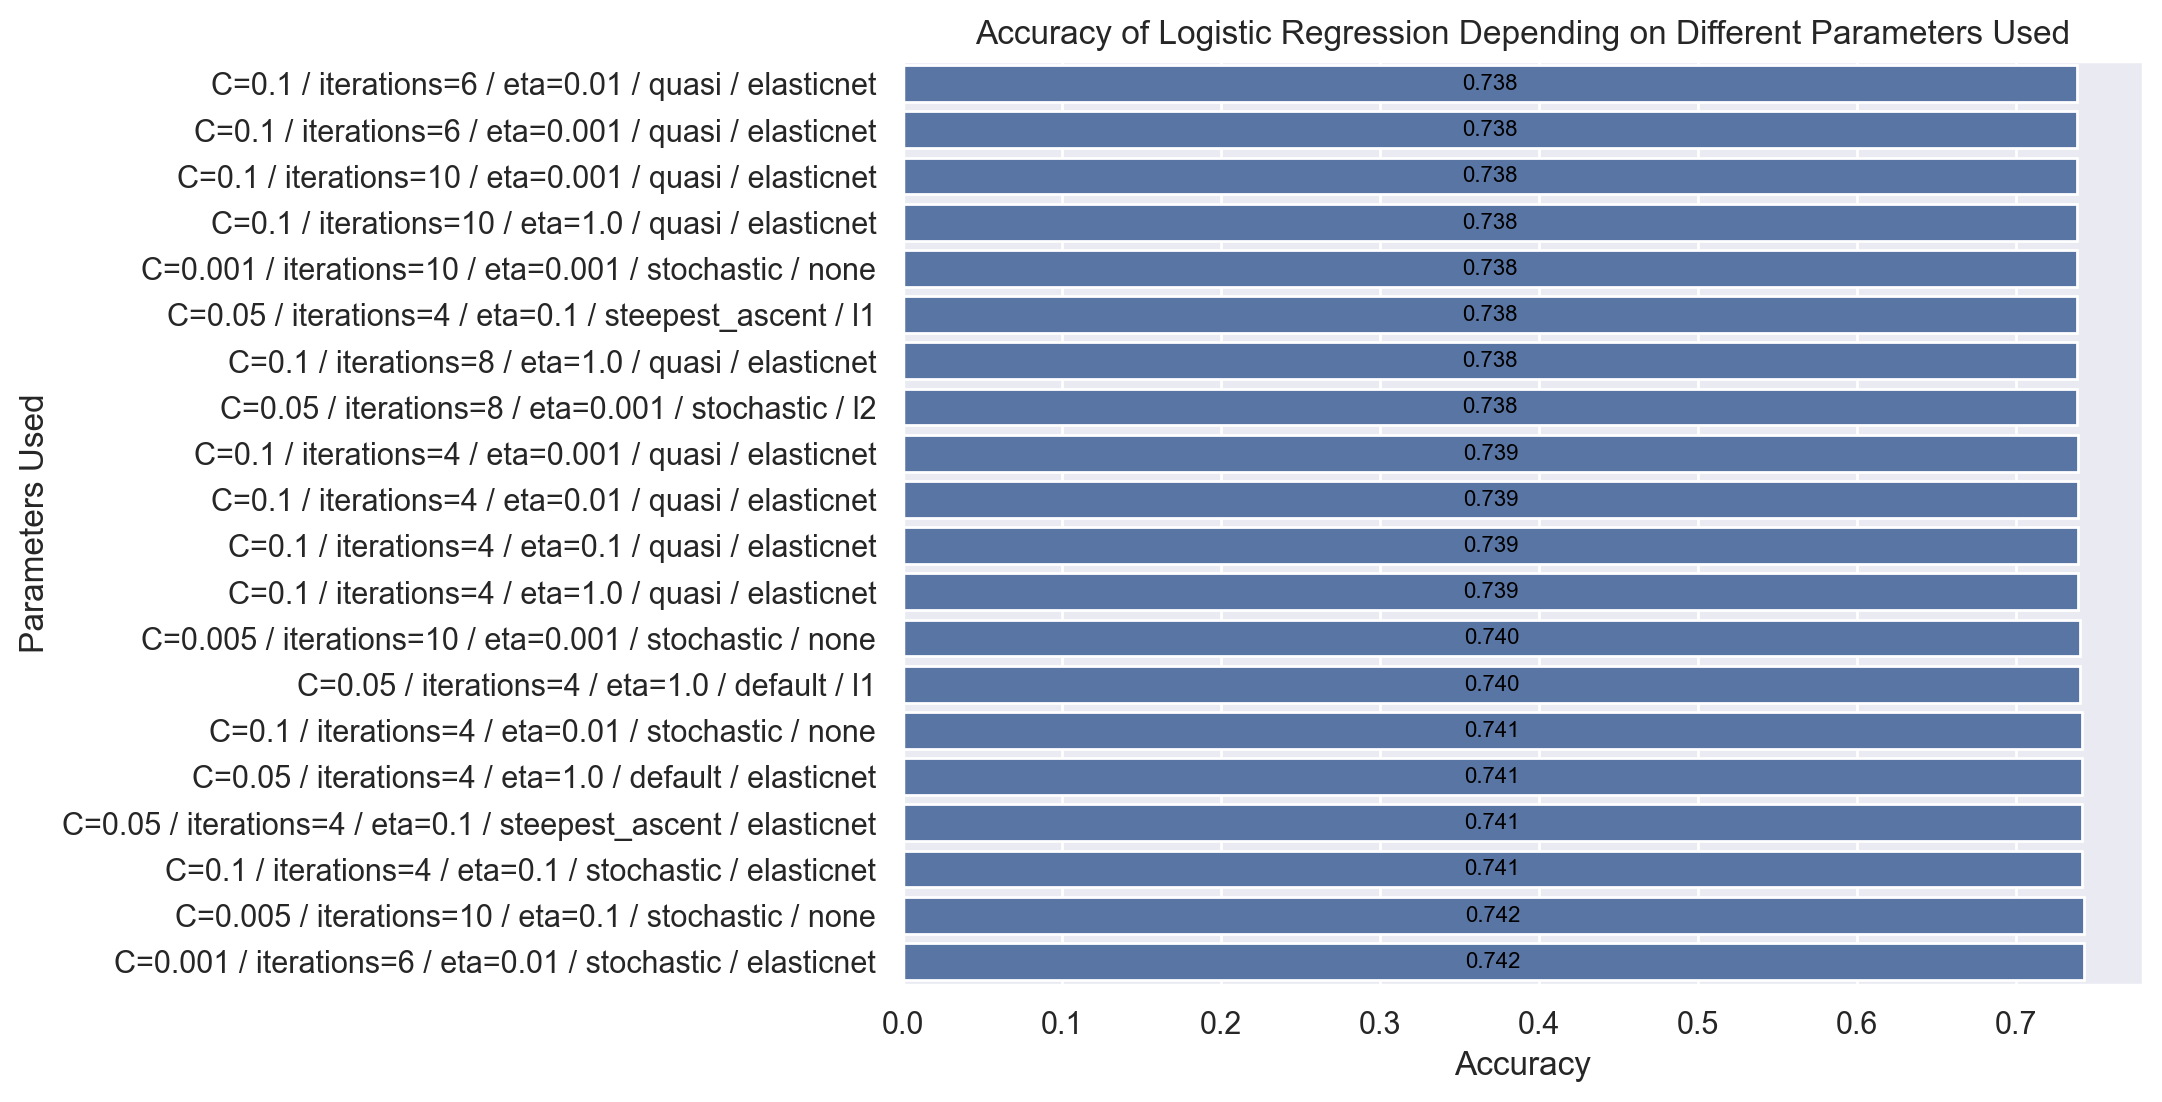

In [12]:
plt.figure(figsize=(8, 6), dpi=200)
ax = sns.barplot(x=np.array(accuracies)[sorted_i][-20:], y=np.array(settings)[sorted_i][-20:]);
ax.set_xlabel("Accuracy")
ax.set_ylabel("Parameters Used")
ax.set_title("Accuracy of Logistic Regression Depending on Different Parameters Used")
for i in ax.containers:
    ax.bar_label(i,fmt='{:.3f}',label_type='center', color='black', fontsize=8)

Though the model with the best performance was not one of the fastest (compared to others that ran under 1 ms), the model ran had a quick runtime of 2.8ms. In general, models running Stochastic Gradient Descent or basic binary logistic regression ran faster than models that ran Steepest Ascent. In conclusion, the best model ran Stochastic Gradient Descent with no Regularization since it had the highest classification accuracy with fairly fast runtime.

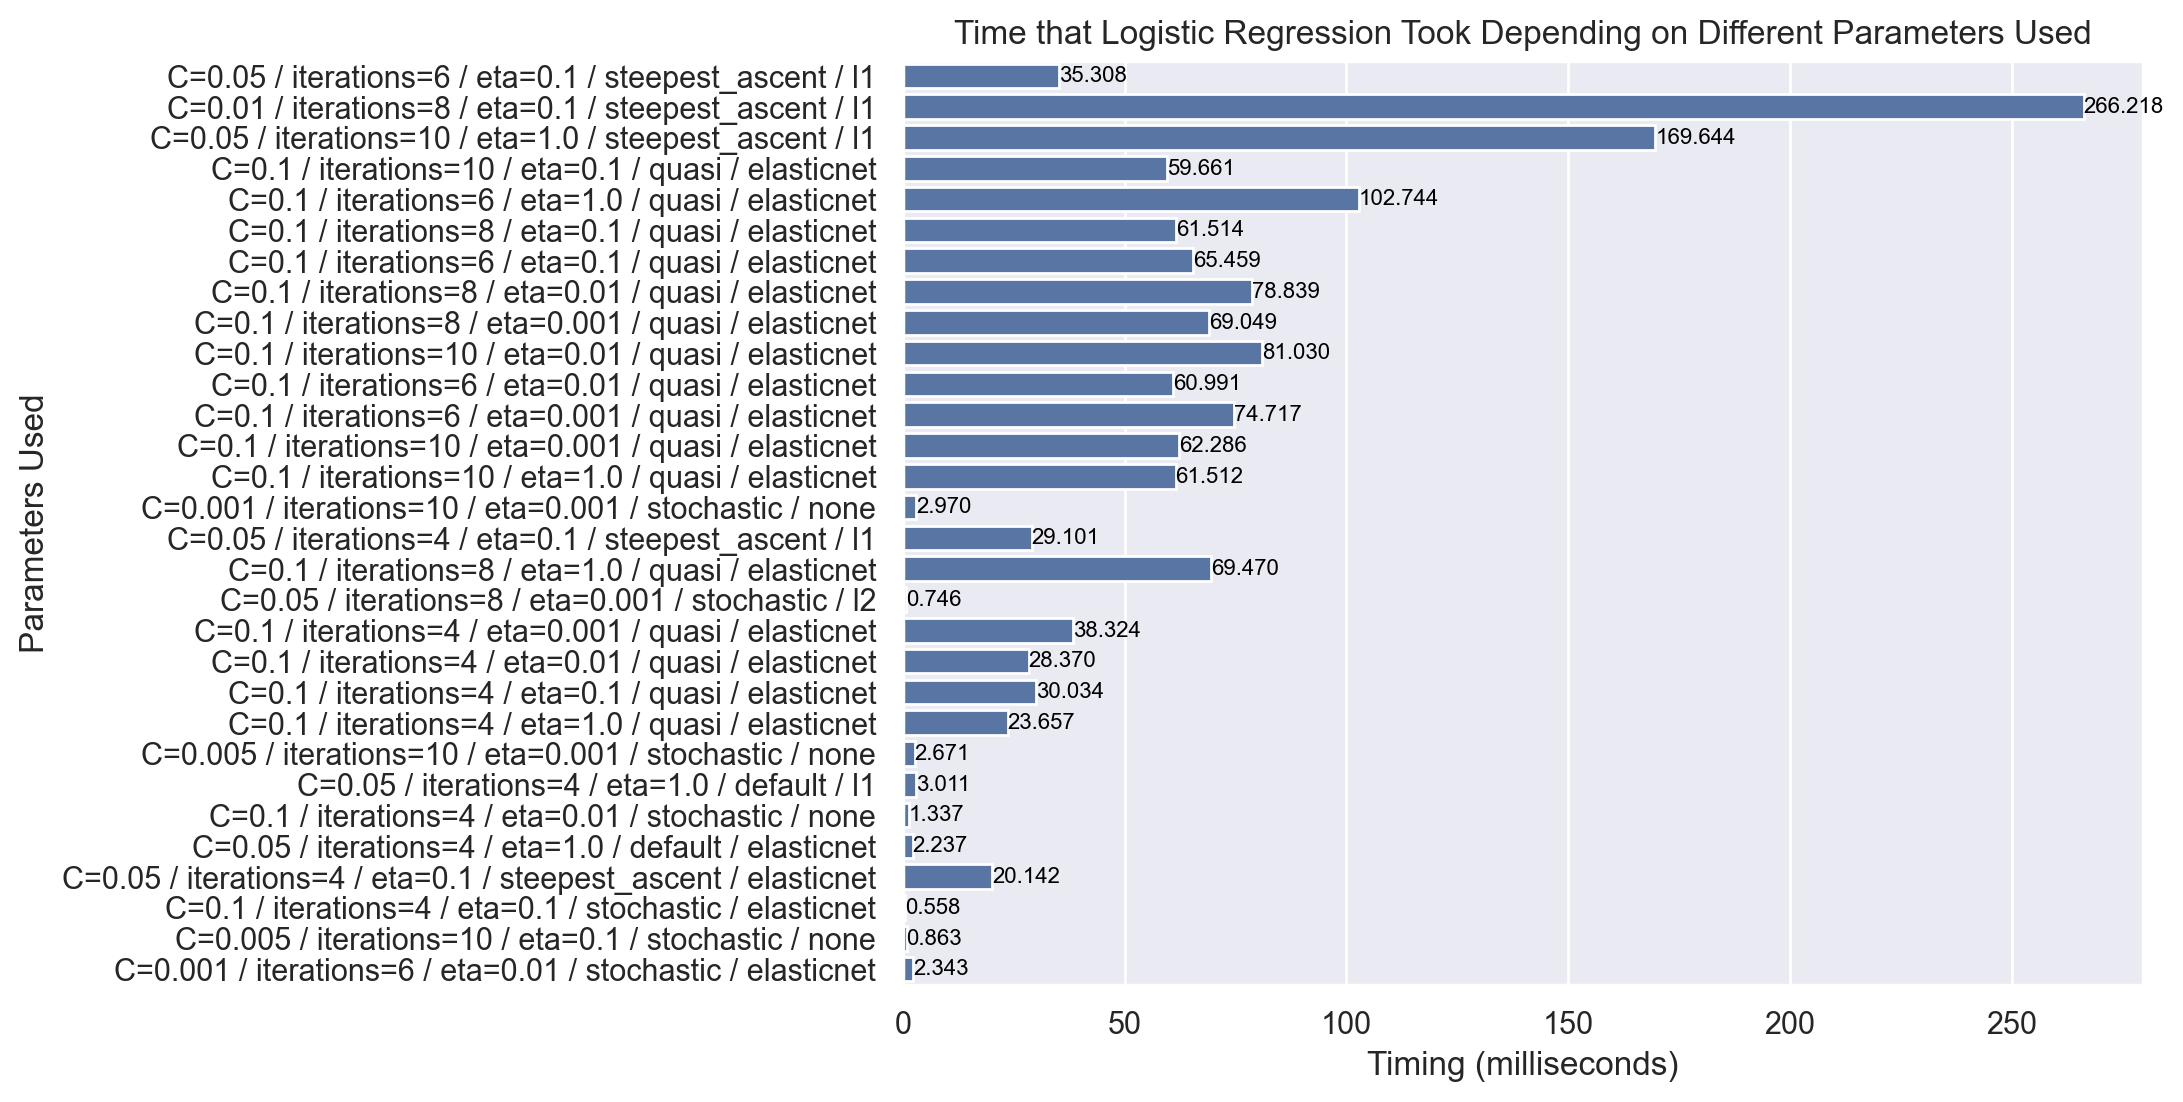

In [13]:
plt.figure(figsize=(8, 6), dpi=200)
ax = sns.barplot(x=np.array(timing)[sorted_i][-30:], y=np.array(settings)[sorted_i][-30:]);
ax.set_xlabel("Timing (milliseconds)")
ax.set_ylabel("Parameters Used")
ax.set_title("Time that Logistic Regression Took Depending on Different Parameters Used")
for i in ax.containers:
    ax.bar_label(i,fmt='{:.3f}',label_type='edge', color='black', fontsize=8)

Our method of selecting parameters may introduce some data snooping and bias into our results. By optimizing the parameters based on our model's performance on the test data, we are fine-tuning the model to fit the test set. Consequently, the model's accuracy on the test data no longer reflects how it would perform on completely new data. To mitigate this issue in the future, we should consider using a separate subset of the data, known as a cross-validation set, for parameter tuning. This way, we can reserve the test data to more accurately assess the model's performance on unseen data.

### 2.3: Comparing to Scikit-Learn

[1.5 points] Compare the performance of your "best" logistic regression optimization procedure to the procedure used in scikit-learn. Visualize the performance differences in terms of training time and classification performance. Discuss the results. 

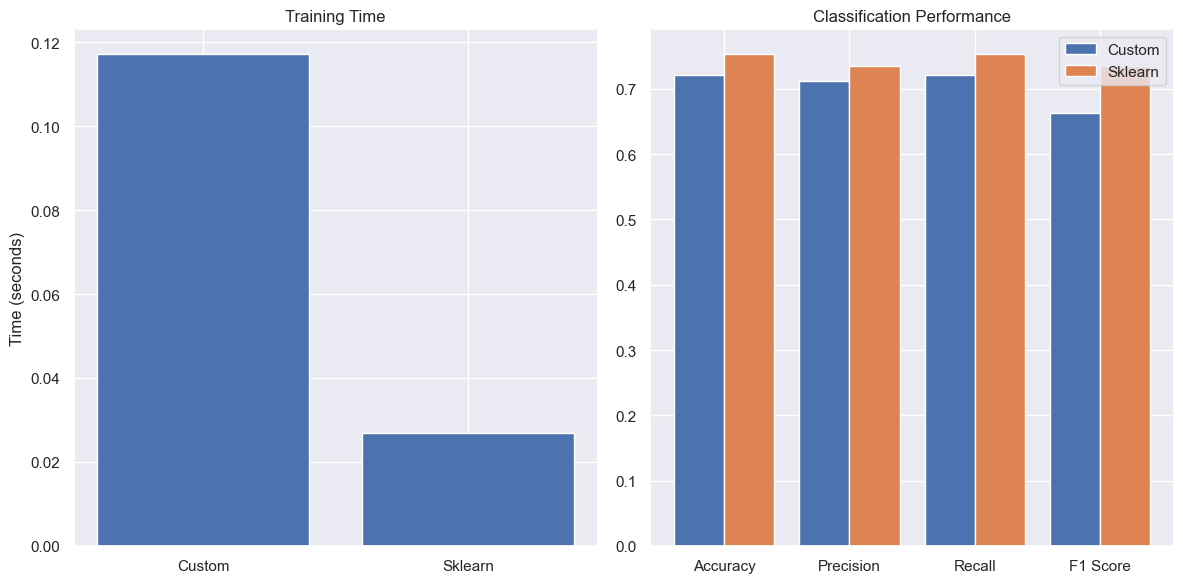

Custom Logistic Regression Training Time: 0.1172 seconds
Scikit-learn Logistic Regression Training Time: 0.0268 seconds

Performance Comparison:
Accuracy: Custom=0.7220, Sklearn=0.7537
Precision: Custom=0.7116, Sklearn=0.7354
Recall: Custom=0.7220, Sklearn=0.7537
F1 Score: Custom=0.6628, Sklearn=0.7357


In [26]:


# Data loading and preprocessing
df = pd.read_csv('data.csv', delimiter=';')
df = df.rename(columns = {
    'Daytime/evening attendance\t' : 'Daytime/evening attendance',               
    'Nacionality': 'Nationality'})
df['Target'].replace({'Dropout' : 1, 'Enrolled' : 2, 'Graduate' : 3}, inplace=True)

# Select relevant features based on correlation
df_target = df.corr()[['Target']]
df_target['abs(Target)'] = df_target['Target'].abs()
corrs = pd.DataFrame(df_target.sort_values(by='abs(Target)', ascending=False)['Target'])
df_less = df[corrs[abs(corrs['Target']) >= 0.1].transpose().columns]
df_less = pd.get_dummies(df_less, prefix='AppMode', columns=['Application mode'], dtype=int)

# Split into features (X) and target (y)
X = df_less.drop('Target', axis=1)
y = df_less['Target']

# Standard scaling of the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Initialize and train the custom MultiClassLogisticRegression model
custom_model = MultiClassLogisticRegression(eta=0.01, iterations=100, C=0.001, solver="default", regularization="l2")

start_time = time.time()
custom_model.fit(X_train, y_train)
custom_train_time = time.time() - start_time

# Predict with custom model
y_pred_custom = custom_model.predict(X_test)

# Train scikit-learn's Logistic Regression model
sklearn_model = LogisticRegression(max_iter=1000)
start_time = time.time()
sklearn_model.fit(X_train, y_train)
sklearn_train_time = time.time() - start_time

# Predict with sklearn model
y_pred_sklearn = sklearn_model.predict(X_test)

# Compute performance metrics for both models
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
custom_metrics = [
    accuracy_score(y_test, y_pred_custom),
    precision_score(y_test, y_pred_custom, average='weighted'),
    recall_score(y_test, y_pred_custom, average='weighted'),
    f1_score(y_test, y_pred_custom, average='weighted')
]

sklearn_metrics = [
    accuracy_score(y_test, y_pred_sklearn),
    precision_score(y_test, y_pred_sklearn, average='weighted'),
    recall_score(y_test, y_pred_sklearn, average='weighted'),
    f1_score(y_test, y_pred_sklearn, average='weighted')
]

# Visualize the training time and performance metrics
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot training time
ax[0].bar(['Custom', 'Sklearn'], [custom_train_time, sklearn_train_time])
ax[0].set_title('Training Time')
ax[0].set_ylabel('Time (seconds)')

# Plot performance metrics
x = range(len(metrics))
ax[1].bar(x, custom_metrics, width=0.4, label='Custom', align='center')
ax[1].bar([p + 0.4 for p in x], sklearn_metrics, width=0.4, label='Sklearn', align='center')
ax[1].set_xticks([p + 0.2 for p in x])
ax[1].set_xticklabels(metrics)
ax[1].set_title('Classification Performance')
ax[1].legend()

plt.tight_layout()
plt.show()

# Print out the metrics for both models
print("Custom Logistic Regression Training Time: {:.4f} seconds".format(custom_train_time))
print("Scikit-learn Logistic Regression Training Time: {:.4f} seconds".format(sklearn_train_time))

print("\nPerformance Comparison:")
for i, metric in enumerate(metrics):
    print(f"{metric}: Custom={custom_metrics[i]:.4f}, Sklearn={sklearn_metrics[i]:.4f}")

## 3: Deployment

Deployment (1 points total)
Which implementation of logistic regression would you advise be used in a deployed machine learning model, your implementation or scikit-learn (or other third party implementation)? Why?

### Exceptional Work: Check *Section 2.2: Finding the Best Performance*
For **Exceptional Work**, we also tested which regularization methods (None, L1, L2, Elastic Net), number of iterations (4, 6, 8, 10), and ETAs resulted in the best performance for our Logistic Regression Model.

### Multiclass Logistic Regression in Two Classes (Unused)

In [14]:
class BinaryLogisticRegression:

    def __init__(self, eta, iterations=20, C=0.001, solver = "default", regularization = "none", line_iters=8):
        self.eta = eta
        self.iters = iterations
        self.C = C

        if solver == "stochastic":
            self._get_gradient = self.stochastic
            self.fit = self.default_fit
        elif solver == "steepest_ascent": 
            # self._get_gradient = self.steepest_ascent
            self.fit = self.fit_steepest
            self.objective_function = self.objective_steepest
            # self.orig_eta = eta
            self.line_iters = line_iters
        elif solver == "newton":
            self._get_gradient = self.newton
            self.fit = self.default_fit
        elif solver == "quasi":
            self.fit = self.fit_bfgs
            self.objective_function = self.objective_quasi
            # self.objective_function = self.mse_quasi
        else:
            self._get_gradient = self.default_gradient
            self.fit = self.default_fit

        if regularization == "l1":
            self.regularization_objective = self.L1_objective
            self.regularization_gradient = self.L1_gradient
        elif regularization == "l2":
            self.regularization_objective = self.L2_objective
            self.regularization_gradient = self.L2_gradient
        elif regularization == "elasticnet":
            self.regularization_objective = self.elasticnet_objective
            self.regularization_gradient = self.elasticnet_gradient
        else:
            self.regularization_objective = self.zero
            self.regularization_gradient = self.zero
        
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'Binary Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained Binary Logistic Regression Object'

    # convenience, private:
    @staticmethod
    def _add_bias(X):
        return np.hstack((np.ones((X.shape[0],1)),X)) # add bias term
    
    @staticmethod
    def _sigmoid(theta):
        # increase stability, redefine sigmoid operation
        return expit(theta) #1/(1+np.exp(-theta))

    """
    All Regularization Functions
    """
    def L2_gradient(self, w_, C):
        return -2 * w_[1:] * C

    def L1_gradient(self, w_, C):
        # -C if weight is < 0, +C if weight is > 0, 0 if weight is 0 (at initialization)
        return C * np.sign(w_[1:])

    def elasticnet_gradient(self, w_, C):
        return self.L1_gradient(w_, C) + self.L2_gradient(w_, C)

    def L2_objective(self, w, C):
        return C*sum(w**2)

    def L1_objective(self, w, C):
        return C*sum(abs(w))

    def elasticnet_objective(self, w, C):
        return self.L1_objective(w, C) + self.L2_objective(w, C)

    def zero(self, w, C):
        return 0

    """
    Objective Functions
    """

    # this defines the function with the first input to be optimized
    # therefore eta will be optimized, with all inputs constant
    def objective_steepest(self,eta,X,y,w,grad,C):
        wnew = w - grad*eta
        g = expit(X @ wnew)
        # the line search is looking for minimization, so take the negative of l(w)
        return -np.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + self.regularization_objective(wnew[1:]**2, C)

    def objective_quasi(self,w,X,y,C):
        g = expit(X @ w) #sigmoid(Xw) to get y predicted
        # invert this because scipy minimizes, but we derived all formulas for maximzing
        return -ma.sum(ma.log(g[y==1]))-ma.sum(ma.log(1-g[y==0])) + self.regularization_objective(w, C)
        #-np.sum(y*np.log(g)+(1-y)*np.log(1-g))

    def mse_quasi(self,w,X,y,C):
        g = expit(X @ w)
        return np.sum(np.power((y-g), 2)) + self.regularization_objective(w, C)
    
    # @staticmethod
    def objective_gradient(self,w,X,y,C):
        g = expit(X @ w) 
        ydiff = y-g # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0)
        gradient = gradient.reshape(w.shape)
        gradient[1:] += self.regularization_gradient(w, C)
        
        return -gradient
    
    """
    All Gradient Functions
    """
    # vectorized gradient calculation with regularization using L2 Norm
    def default_gradient(self,X,y):
        ydiff = y-self.predict_proba(X,add_bias=False).ravel() # get y difference
        gradient = np.mean(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self.regularization_gradient(self.w_, self.C)
        
        return gradient
    
    def stochastic(self,X,y):
        # grab a subset of samples in a mini-batch
        # and calculate the gradient according to the small batch only
        mini_batch_size = 16
        idxs = np.random.choice(len(y), mini_batch_size)
        
        ydiff = y[idxs]-self.predict_proba(X[idxs],add_bias=False).ravel() # get y difference (now scalar)
        gradient = np.mean(X[idxs] * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self.regularization_gradient(self.w_, self.C)
        
        return gradient

    def newton(self,X,y):
        g = self.predict_proba(X,add_bias=False).ravel() # get sigmoid value for all classes
        hessian = X.T @ np.diag(g*(1-g)) @ X - 2 * self.C # calculate the hessian

        ydiff = y-g # get y difference
        gradient = np.sum(X * ydiff[:,np.newaxis], axis=0) # make ydiff a column vector and multiply through
        gradient = gradient.reshape(self.w_.shape)
        gradient[1:] += self.regularization_gradient(self.w_, self.C)
        
        return pinv(hessian) @ gradient
        
    # public:
    def predict_proba(self,X,add_bias=True):
        # add bias term if requested
        Xb = self._add_bias(X) if add_bias else X
        return self._sigmoid(Xb @ self.w_) # return the probability y=1
    
    def predict(self,X):
        return (self.predict_proba(X)>0.5) #return the actual prediction
    
    """
    All Fit Functions
    """
    def default_fit(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = self._get_gradient(Xb,y)
            self.w_ += gradient*self.eta # multiply by learning rate 
            # add bacause maximizing 

    def fit_steepest(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = np.zeros((num_features,1)) # init weight vector to zeros
        
        # for as many as the max iterations
        for _ in range(self.iters):
            gradient = -self.default_gradient(Xb,y)
            # minimization is in opposite direction
            
            # do line search in gradient direction, using scipy function
            opts = {'maxiter':self.line_iters} # unclear exactly what this should be
            res = minimize_scalar(self.objective_function, # objective function to optimize
                                  bounds=(0,self.eta*10), #bounds to optimize
                                  args=(Xb,y,self.w_,gradient,self.C), # additional argument for objective function
                                  method='bounded', # bounded optimization for speed
                                  options=opts) # set max iterations
            
            eta = res.x # get optimal learning rate
            self.w_ -= gradient*eta # set new function values
    
    def fit_bfgs(self, X, y):
        Xb = self._add_bias(X) # add bias term
        num_samples, num_features = Xb.shape
        
        self.w_ = fmin_bfgs(self.objective_function, # what to optimize
                            np.zeros((num_features,1)), # starting point
                            fprime=self.objective_gradient, # gradient function
                            args=(Xb,y,self.C), # extra args for gradient and objective function
                            gtol=1e-03, # stopping criteria for gradient, |v_k|
                            maxiter=self.iters, # stopping criteria iterations
                            disp=False)
        
        self.w_ = self.w_.reshape((num_features,1))


In [15]:
# allow for the user to specify the algorithm they want to solver the binary case
class MultiClassLogisticRegression:
    def __init__(self, eta, iterations=20, 
                 C=0.0001, 
                 solver = "default",
                 regularization = "none", 
                 line_iters=8
                 ):
        self.eta = eta
        self.iters = iterations
        self.C = C
        self.solver = solver
        self.regularization = regularization
        self.line_iters = line_iters
        self.classifiers_ = []
        # internally we will store the weights as self.w_ to keep with sklearn conventions
    
    def __str__(self):
        if(hasattr(self,'w_')):
            return 'MultiClass Logistic Regression Object with coefficients:\n'+ str(self.w_) # is we have trained the object
        else:
            return 'Untrained MultiClass Logistic Regression Object'
        
    def fit(self,X,y):
        num_samples, num_features = X.shape
        self.unique_ = np.sort(np.unique(y)) # get each unique class value
        num_unique_classes = len(self.unique_)
        self.classifiers_ = []
        for i,yval in enumerate(self.unique_): # for each unique value
            y_binary = np.array(y==yval).astype(int) # create a binary problem
            # train the binary classifier for this class
            
            hblr = BinaryLogisticRegression(
                eta=self.eta,iterations=self.iters,C=self.C,
                solver=self.solver, regularization=self.regularization, line_iters=self.line_iters
            )
            hblr.fit(X,y_binary)

            # add the trained classifier to the list
            self.classifiers_.append(hblr)
            
        # save all the weights into one matrix, separate column for each class
        self.w_ = np.hstack([x.w_ for x in self.classifiers_]).T
        
    def predict_proba(self,X):
        probs = []
        for hblr in self.classifiers_:
            probs.append(hblr.predict_proba(X).reshape((len(X),1))) # get probability for each classifier
        
        return np.hstack(probs) # make into single matrix
    
    def predict(self,X):
        return self.unique_[np.argmax(self.predict_proba(X),axis=1)] # take argmax along row
    